## 数据加载

In [28]:
from utils import *

In [37]:


# 1. 加载数据
file_path = 'data/summerOly_athletes_total_with_types.csv'
data = pd.read_csv(file_path)

# 2. 数据预处理

# 获取独特的运动项目、年份和代表队
sports = sorted(data['Type'].unique())  # 运动项目 S
years = sorted(data['Year'].unique())   # 奥运会年份 T
nocs = sorted(data['NOC'].unique())     # 国家代表队 N

# 构建映射表
sport_to_idx = {sport: i for i, sport in enumerate(sports)}
year_to_idx = {year: i for i, year in enumerate(years)}
noc_to_idx = {noc: i for i, noc in enumerate(nocs)}
print(sport_to_idx)
print(noc_to_idx)

# 保存映射表
np.save('data/noc_to_idx.npy', noc_to_idx)

S, T, N = len(sports), len(years), len(nocs)

# 3. 奖牌分布数据
result_tensor = np.zeros((S, T, N), dtype=float)

# 过滤掉没有奖牌的数据
data = data[data['Medal'] != 'No medal']
# 去重
data = data.drop_duplicates(subset=['Event', 'Year', 'Medal', 'NOC', 'Sport'])
# 保存去重后的数据
data.to_csv('data/summerOly_athletes_no_dup.csv', index=False)
                                      
# 3. 构建张量
for _, row in data.iterrows():
    sport_idx = sport_to_idx[row['Type']]
    year_idx = year_to_idx[row['Year']]
    noc_idx = noc_to_idx[row['NOC']]
    result_tensor[sport_idx, year_idx, noc_idx] += 1.0  # 标记该国家在该年该运动有奖牌



# 4. 保存结果
output_path = 'data/olympic_medals_with_type.npy'
np.save(output_path, result_tensor)
print(f"结果张量已保存到 {output_path}")
print(f"张量形状: {result_tensor.shape}")  # 输出 S*T*N 的张量形状





{'Artistic Sports': 0, 'Athletics': 1, 'Combat Sports': 2, 'Cycling Sports': 3, 'Endurance Sports': 4, 'Equestrian': 5, 'Extreme Sports': 6, 'Gymnastics': 7, 'Other Traditional Sports': 8, 'Racket Sports': 9, 'Small Ball Sports': 10, 'Team Ball Sports': 11, 'Water Sports': 12, 'Weapon Sports': 13, 'Winter Sports': 14}
{'AFG': 0, 'AHO': 1, 'AIN': 2, 'ALB': 3, 'ALG': 4, 'AND': 5, 'ANG': 6, 'ANT': 7, 'ANZ': 8, 'ARG': 9, 'ARM': 10, 'ARU': 11, 'ASA': 12, 'AUS': 13, 'AUT': 14, 'AZE': 15, 'BAH': 16, 'BAN': 17, 'BAR': 18, 'BDI': 19, 'BEL': 20, 'BEN': 21, 'BER': 22, 'BHU': 23, 'BIH': 24, 'BIZ': 25, 'BLR': 26, 'BOH': 27, 'BOL': 28, 'BOT': 29, 'BRA': 30, 'BRN': 31, 'BRU': 32, 'BUL': 33, 'BUR': 34, 'CAF': 35, 'CAM': 36, 'CAN': 37, 'CAY': 38, 'CGO': 39, 'CHA': 40, 'CHI': 41, 'CHN': 42, 'CIV': 43, 'CMR': 44, 'COD': 45, 'COK': 46, 'COL': 47, 'COM': 48, 'CPV': 49, 'CRC': 50, 'CRO': 51, 'CRT': 52, 'CUB': 53, 'CYP': 54, 'CZE': 55, 'DEN': 56, 'DJI': 57, 'DMA': 58, 'DOM': 59, 'ECU': 60, 'EGY': 61, 'EOR': 

In [15]:
# 检查
total = result_tensor[:,year_to_idx[2024],noc_to_idx['CHN']].sum()
print(total)


91.0


## 平滑操作

In [4]:
sport_to_idx_inv = {v: k for k, v in sport_to_idx.items()}
for idx in range(S):
    # 加载某一项运动对应的数据作为时间序列数据用于训练
    medal_dist = torch.tensor(np.load('data/olympic_medals_with_type.npy')[idx], dtype=torch.float32).numpy()

    # 加载对应的运动员数量-国家分布作为平滑参数
    sport = sport_to_idx_inv[idx]
    file_path = f'data/athletes_count/{sport}.csv'
    athletes_count = pd.read_csv(file_path)
    # 列索引中年份并不是顺序的，需要重新排序
    years = sorted(athletes_count.columns)
    athletes_count = athletes_count[years]
    # 重新组织列表，使其行的顺序与noc_to_idx一致
    athletes_count.set_index(athletes_count.columns[-1], inplace=True)
    athletes_count = athletes_count.reindex(nocs)
    athletes_count.reset_index(inplace=True)
    # 将数据转换为 NumPy 数组
    athletes_per_noc = athletes_count.values
    # 每一行的最后一项是NOC并转置，使每一行表示每一年的运动员数量-国家分布
    athletes_per_noc = athletes_per_noc[:, 1:].T


    # 对每个年份的分布进行平滑处理
    for i in range(T):
        medal_dist[i] = smooth_distribution(medal_dist[i], athletes_per_noc[i], smooth_factor=0.1, reduce_factor=0.05)
    # 保存平滑后的数据
    np.save(f'data/medals_dist_smoothed/{idx}.npy', medal_dist)


## 训练模型 （针对每一类运动）

In [5]:
for idx in range(S):  

    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
    # x = torch.tensor(np.load('data/olympic_medals.npy')[idx], dtype=torch.float32)

    T, N = x.size()  # 时间序列长度和向量维度

    # 实例化模型
    model = WeightOptimizer(T)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练循环
    num_epochs = 10000
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # 清除梯度
        loss = model(x)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重参数
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    # 查看学习到的权重
    weights = model.weights
    weights = weights.detach().numpy()
    # 保存学习到的权重
    np.save(f'data/weights/{idx}.npy', weights)

    print(f"Learned weights for {idx}-th sport:", weights)


Epoch 100/10000, Loss: 20.8649
Epoch 200/10000, Loss: 19.8530
Epoch 300/10000, Loss: 19.0979
Epoch 400/10000, Loss: 18.4451
Epoch 500/10000, Loss: 17.8077
Epoch 600/10000, Loss: 17.1840
Epoch 700/10000, Loss: 16.5935
Epoch 800/10000, Loss: 16.0976
Epoch 900/10000, Loss: 15.7909
Epoch 1000/10000, Loss: 15.6750
Epoch 1100/10000, Loss: 15.6064
Epoch 1200/10000, Loss: 15.5371
Epoch 1300/10000, Loss: 15.4624
Epoch 1400/10000, Loss: 15.3789
Epoch 1500/10000, Loss: 15.2804
Epoch 1600/10000, Loss: 15.1495
Epoch 1700/10000, Loss: 14.8718
Epoch 1800/10000, Loss: 14.3432
Epoch 1900/10000, Loss: 15.7591
Epoch 2000/10000, Loss: 14.5956
Epoch 2100/10000, Loss: 13.4063
Epoch 2200/10000, Loss: 13.2193
Epoch 2300/10000, Loss: 13.1980
Epoch 2400/10000, Loss: 13.1829
Epoch 2500/10000, Loss: 13.1701
Epoch 2600/10000, Loss: 13.1582
Epoch 2700/10000, Loss: 13.1469
Epoch 2800/10000, Loss: 13.1359
Epoch 2900/10000, Loss: 13.1251
Epoch 3000/10000, Loss: 13.1148
Epoch 3100/10000, Loss: 13.1061
Epoch 3200/10000,

In [29]:
# 测试模型，使用2024以前的数据预测2024的国家奖牌总数（即所有运动的奖牌分布之和）
pred_medals = np.zeros(N)
target = 30 # 2024年奖牌总数


for idx in range(S):
    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
    # 转换为NumPy数组
    x = x.detach().numpy()

    # 加载学习到的权重
    weights = np.load(f'data/weights/{idx}.npy')
    weights[-1] = weights[-2] 

    # 乘以距离权重
    dist = torch.tensor([i for i in range(target, 0, -1)], dtype=torch.float32)  # (k,)
    # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
    dist_weights = inverse_sigmoid(dist).detach().numpy()  # (k,)

    # 最终权重为原始权重和距离权重的乘积
    k_weights = dist_weights * weights[:target]  # (k,)
    k_weights = k_weights / np.sum(k_weights)
    # 计算预测值
    x_pred = np.sum(k_weights.reshape(-1,1) * x[:target], axis=0)

    # 将预测值累加到总预测奖牌数
    pred_medals += x_pred 


# 输出预测结果 
# 使用总奖牌数rescale
total_medals_list = np.load('data/total_medals_list.npy')
pred_medals = pred_medals / sum(pred_medals) * total_medals_list[year_to_idx[2024]]
# 保存预测结果
np.save('data/result/pred_medals_test.npy', pred_medals)

# 找到预测结果最大的二十个国家的索引
idx_to_noc = {v: k for k, v in noc_to_idx.items()}
max_indices = np.argsort(pred_medals)[-20:]  # 获取前20名索引
# 倒排
max_indices = max_indices[::-1]
print("Top 20 countries with predicted medals in 2024:", [idx_to_noc[idx] for idx in max_indices])
print("Predicted medal counts:", pred_medals[max_indices])


Top 20 countries with predicted medals in 2024: ['USA', 'CHN', 'GBR', 'GER', 'JPN', 'RUS', 'AUS', 'FRA', 'ITA', 'KOR', 'NED', 'CAN', 'UKR', 'CUB', 'BRA', 'ROC', 'ESP', 'HUN', 'NZL', 'POL']
Predicted medal counts: [117.39347567  85.4765616   59.16505779  44.96561868  44.8529281
  44.60236768  43.84434176  37.3625238   34.05865446  26.53978524
  24.6924244   22.04296717  19.89889828  19.60437614  19.14303686
  18.34955439  18.09353826  15.83559019  14.60878935  13.80631247]


## 可视化与评估

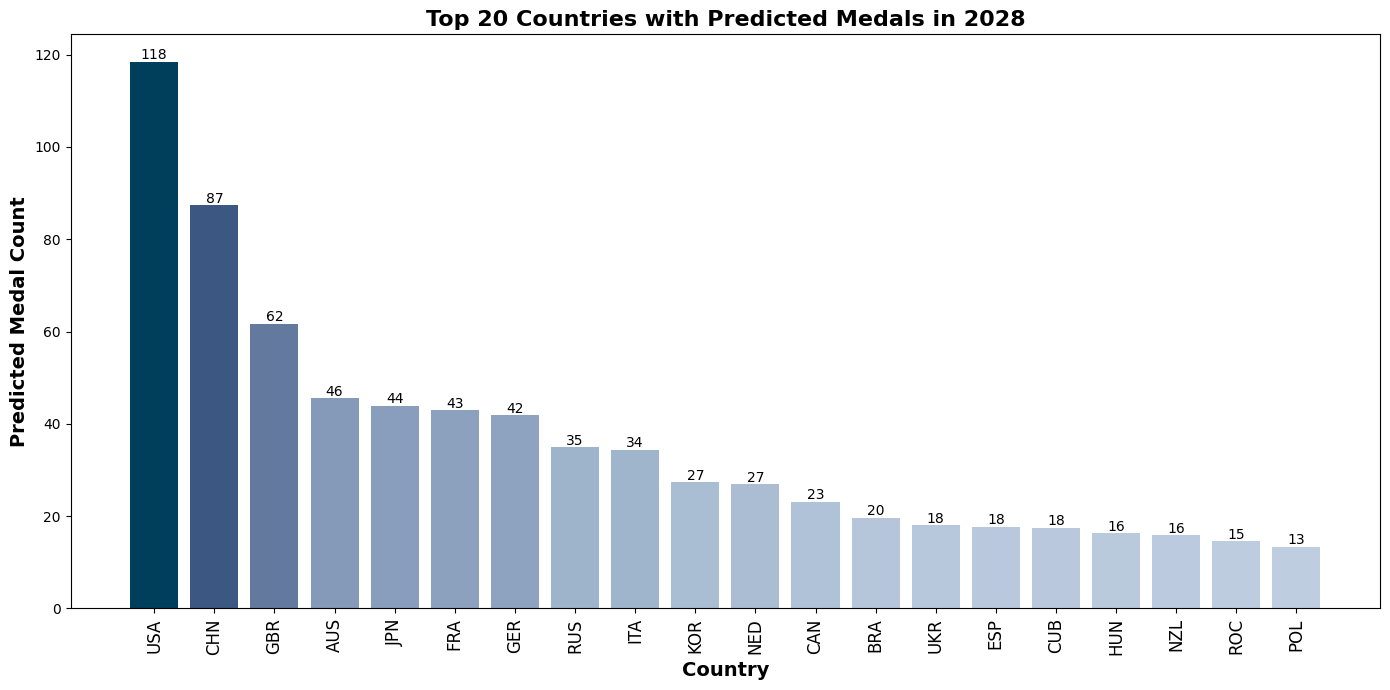

In [14]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# 加载pred_medals
pred_medals = np.load('data/result/pred_medals_test.npy') 
# rescale
total_medals_list = np.load('data/total_medals_list.npy')
pred_medals = pred_medals / sum(pred_medals) * total_medals_list[year_to_idx[2024]]

max_indices = np.argsort(pred_medals)[-20:]  # 获取前20名索引
# 倒排
max_indices = max_indices[::-1]
# 自定义蓝色系渐变，避免最高值出现偏红色
colors = ["#bfcde0", "#9eb5cc", "#6e81a8", "#4a6587", "#2f4b7c", "#003f5c"]
custom_cmap = LinearSegmentedColormap.from_list("custom_blues", colors)

# 假设 pred_medals 和 max_indices 已定义
# 动态生成 x 轴
x = range(1, len(max_indices) + 1)

# 生成颜色映射
norm = plt.Normalize(vmin=min(pred_medals[max_indices]), vmax=max(pred_medals[max_indices]))
colors = custom_cmap(norm(pred_medals[max_indices]))  # 根据数据生成蓝色系渐变颜色

# 绘制柱状图
plt.figure(figsize=(14, 7))  # 增加图表大小
plt.bar(x, pred_medals[max_indices], color=colors)

# 设置 x 轴标签为国家名称
plt.xticks(x, [idx_to_noc[idx] for idx in max_indices], rotation=90, fontsize=12)

# 添加数值标签
for i, value in enumerate(pred_medals[max_indices]):
    plt.text(x[i], value + 0.5, f"{value:.0f}", ha='center', fontsize=10, color='black')

# 设置图表信息（标题和轴标题字体更大并加粗）
plt.xlabel('Country', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Medal Count', fontsize=14, fontweight='bold')
plt.title('Top 20 Countries with Predicted Medals in 2028', fontsize=16, fontweight='bold')

# 自动调整布局避免重叠
plt.tight_layout()
plt.show()


In [36]:
import numpy as np
from scipy.stats import pearsonr

def calculate_metrics(true_values, predicted_values, k=7):
    """
    计算均绝对百分比误差 (MAPE)、皮尔逊相关系数 (PCC) 和 Top-k 准确率
    
    参数:
    - true_values: 真实值的 N 维向量 (numpy array)
    - predicted_values: 预测值的 N 维向量 (numpy array)
    - k: 用于 Top-k 准确率的阈值 (默认 10)
    
    返回:
    - MAPE: float
    - PCC: float
    - Top-k 准确率: float
    """
    # 1. 计算均绝对百分比误差 (MAPE)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

    # 2. 计算皮尔逊相关系数 (PCC)
    pcc, _ = pearsonr(true_values, predicted_values)

    # 3. 计算 Top-k 准确率
    # 排序索引
    true_top_k = set(np.argsort(true_values)[-k:])  # 真实值的 Top-k 索引
    predicted_top_k = set(np.argsort(predicted_values)[-k:])  # 预测值的 Top-k 索引
    top_k_accuracy = len(true_top_k.intersection(predicted_top_k)) / k  # 交集数目 / k

    return mape, pcc, top_k_accuracy

# 加载真实值和预测值
true_values_all = np.load('data/medal_count.npy')
true_values = true_values_all[year_to_idx[2024]]
pred_values = np.load('data/result/pred_medals_test.npy') 

# 计算指标
mape, pcc, top_k_accuracy = calculate_metrics(true_values, pred_values, k=10)

# 打印结果
print(f"Mean Absolute Percentage Error (MAPE): {mape:.5f}%")
print(f"Pearson Correlation Coefficient (PCC): {pcc:.5f}")
print(f"Top-k Accuracy (k=7): {top_k_accuracy:.5f}")


Mean Absolute Percentage Error (MAPE): inf%
Pearson Correlation Coefficient (PCC): 0.94461
Top-k Accuracy (k=7): 0.90000


/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
